# Исследование методов классификации изображений рукописных цифр с помощью сверточной нейронной сети

Дисциплина: "**Системы поддержки принятия решений**"

**Подготовил**: Лосев А. П., гр. ИСТ-131м, **вариант 6**.

Метод оптимизации — **SGD**, метод активации — **ReLU**, шаг градиентного спуска — **0,01**.

**Принял**: к.т.н., доцент кафедры ИУС, Литвинов В. Л.

Импорт необходимых зависимостей и инициализация *random seed*:

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Импорт встроенных наборов для обучения

In [2]:
import torchvision.datasets

Загрузка датасетов MNIST для обучения и валидации результатов:

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Размещение загруженных датасетов в переменные:

In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Вывод информации о количестве индивидуальных единиц данных в датасетах:

In [5]:
len(y_train), len(y_test)

(60000, 10000)

Представление данных в датасете через числа с плавающей точкой для удобства манипулирования:

In [6]:
X_train = X_train.float()
X_test = X_test.float()

Вывод на график единичного изображения цифры из набора для обучения:

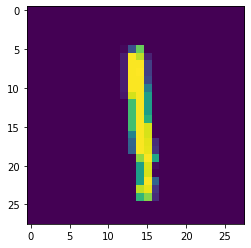

tensor(1)


In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[8, :, :])
plt.show()
print(y_train[8])

Представление изображений из датасета как трёхмерных тензоров:

In [8]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

Вывод информации о размерности набора данных для обучения, где указано количество изображений (**60000**) и размерность тензора изображения (**1x28x28**):

In [9]:
X_train.shape

torch.Size([60000, 1, 28, 28])

Создание модели нейронной сети по подобию с сетью ЛеКуна при помощи наследования от класса *Module*:

In [10]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

Выбор графического ускорителя как приоритетного устройства для выполнения вычислений:

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

Создание функции потерь и оптимизатора:

In [12]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet5.parameters(), lr=1.0e-2)

Обучение нейронной сети на тестовом наборе данных:

In [13]:
%%time
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.7937)
tensor(0.8943)
tensor(0.9236)
tensor(0.9390)
tensor(0.9486)
tensor(0.9558)
tensor(0.9613)
tensor(0.9665)
tensor(0.9695)
tensor(0.9718)
tensor(0.9739)
tensor(0.9758)
tensor(0.9745)
tensor(0.9783)
tensor(0.9788)
tensor(0.9798)
tensor(0.9813)
tensor(0.9805)
tensor(0.9815)
tensor(0.9822)
tensor(0.9827)
tensor(0.9823)
tensor(0.9834)
tensor(0.9842)
tensor(0.9841)
tensor(0.9840)
tensor(0.9834)
tensor(0.9845)
tensor(0.9844)
tensor(0.9852)
tensor(0.9857)
tensor(0.9856)
tensor(0.9860)
tensor(0.9855)
tensor(0.9858)
tensor(0.9867)
tensor(0.9864)
tensor(0.9862)
tensor(0.9869)
tensor(0.9874)
tensor(0.9870)
tensor(0.9886)
tensor(0.9877)
tensor(0.9874)
tensor(0.9880)
tensor(0.9870)
tensor(0.9878)
tensor(0.9882)
tensor(0.9889)
tensor(0.9872)
tensor(0.9879)
tensor(0.9876)
tensor(0.9874)
tensor(0.9880)
tensor(0.9879)
tensor(0.9881)
tensor(0.9883)
tensor(0.9885)
tensor(0.9888)
tensor(0.9885)
tensor(0.9888)
tensor(0.9887)
tensor(0.9886)
tensor(0.9881)
tensor(0.9899)
tensor(0.9900)
tensor(0.9

Вывод информации о базовом тензоре из тестового набора данных:

In [14]:
lenet5.forward(X_test)

tensor([[-0.4910,  0.0477,  0.5417,  ..., 12.9238, -2.1081,  2.7101],
        [ 2.4520,  0.8093, 12.2178,  ..., -5.3480,  2.1526, -2.9404],
        [-2.3685, 12.4361, -1.0142,  ...,  1.4449, -0.0448, -4.2194],
        ...,
        [-4.1308,  0.5742, -4.3452,  ...,  0.9044,  1.0055,  1.6071],
        [-0.8059, -3.3774, -4.0473,  ..., -5.7716,  6.3763, -2.3795],
        [ 1.6100, -3.3545,  0.1102,  ..., -9.4266,  0.5856, -2.7137]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

Графическая репрезентация точности прогнозирования:

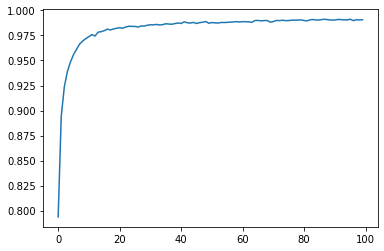

In [15]:
plt.plot(test_accuracy_history);

Графическая репрезентация функции потерь:

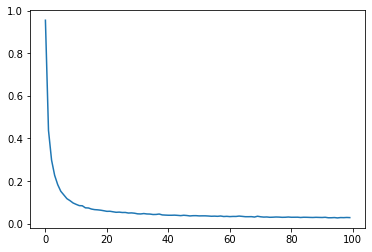

In [16]:
plt.plot(test_loss_history);

Вывод информации о цифре из тестового датасета:

In [17]:
print(y_test[108])

tensor(9, device='cuda:0')


Считывание значения из тестового датасета и запись в отдельную переменную:

In [18]:
X_test1 = X_test[108, :, :, :]

Преобразование переменной в формат данных, удобный для представления и манипуляции:

In [19]:
X_test1 = X_test1.unsqueeze(0).float()

Вывод информации о размерности переменной:

In [20]:
X_test1.shape

torch.Size([1, 1, 28, 28])

Вызов созданной функции *forward* для переменной:

In [21]:
lenet5.forward(X_test1)

tensor([[-3.9393, -3.5282, -1.5161, -0.1960,  3.3509, -0.1077, -6.1747,  0.1115,
          2.3598, 12.8691]], device='cuda:0', grad_fn=<AddmmBackward0>)

Перенос переменной с *GPU* на *CPU* для возможности вывода на график:

In [22]:
X_test1 = X_test[108, 0, :, :].to('cpu')

Вывод цифры из тестового датасета на график:

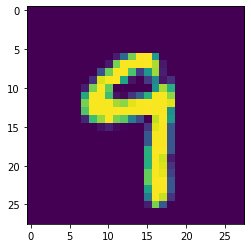

In [23]:
plt.imshow(X_test1)
plt.show()

***
**Задание на лабораторную работу**
***

1. Изучить понятия: **свёртка**, **паддинг**, **страйд**, ***average_pooling***, ***max_pooling***;
2. Исследовать нейронную сеть при заданных начальных параметрах (**вариант 6**);
3.	Исследовать зависимость точности распознавания от количества слоев, метода активации (например, *ReLU*), шага *lr* и типа пулинга;
4.	Замерьте время вычисления 100 эпох на CPU и на GPU. Какое ускорение вы наблюдаете?;
5. Попробуйте добиться качества 0.992  на данном датасете;

    `Обратите внимание на следующие моменты:`
    
    Появляется ли у вас переобучение при увеличении количества эпох?
    
    Как добавление различных слоев влияет на скорость обучения (какие слои быстрее: сверточные или полносвязные)?
    
    
6. Проверьте верность распознавания на нескольких примерах входных данных.

***
**Ответы на задание**
***

1. **Свёртка** — операция с матрицами, заключающаяся в фильтрации матрицы во время сканирования при помощи скользящего окна определённой размерности. **Паддинг** — увеличение размера матрицы до величины, кратной размеру скользящего окна, для корректной работы фильтра. **Страйд** — размер окна для свёртки. ***average_pooling*** — свёртка с записью среднего значения значений массива, образованных страйдом. ***max_pooling*** — свёртка с записью наибольшего значения значений массива, образованных страйдом.
   
2. Для данной нейронной сети базовые значения, указанные для **варианта 6**, дали положительные результаты, так как уже через **10 эпох** нейросеть выдаёт результат точности, составляющий **0.9883**. Данный показатель является положительным результатом, однако существует возможность для дополнительной оптимизации модели.

3. Уменьшение шага *lr* дало уменьшение точности прогнозирования и увеличение времени обучения сети. Изменение функции активации на *Sigmoid* вместо *ReLU* дало значительно меньшую точность прогнозирования (около **0.8773** вместо **0.9987** для *ReLU*), а также увеличило время обучения в полтора раза. Добавление дополнительного слоя нейронной сети перед преобразованием данных в одномерный вектор дало лишь небольшое увеличение промежутка времени обучения (приближённо на **2 минуты**), а также снижение точности прогнозирования на **0.0376**. Изменение вида пуллинга с *Average Pooling* на *Max Pooling* не дало существенных отличий в точности, однако увеличило время обучения на **1 минуту и 23 секунды**.

4. Для данной нейронной сети наблюдается выполнение обучения в **100 эпох** за **20 минут и 13 секунд** при использовании **CPU**, а при использовании **GPU** — за **9 минут и 33 секунды**.

5. Точность прогнозирования до показателя **0.992** повысить не получилось однако наилучший показатель, который показала нейросеть — **0.9916**.

6. При валидации верности распознавания значения из тестового датасета и прогнозы обученной нейросети совпали во всех случаях тестирования.

**Выводы**: при выполнении лабораторной работы были получены практические навыки разработки свёрточной нейронной сети, был изучен алгоритм свёртки, принципы манипуляции точностью обучения, а также различные виды пуллинга для усреднения значений при свёртке. Были также разобраны и выяснены причины, по которым свёрточные нейронные сети являются подходящим инструментом для классификации изображений.